link to data: https://drive.google.com/file/d/14FdevY2Gxdyt2eI8amPYP_I3aTmIu5l1/view?usp=sharing

# 0. Imports


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models  import Sequential
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D, Dropout

In [ ]:
!pip install split_folders

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import zipfile
import os
import enum

import splitfolders

## 0.1 Mounting Drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# data zip
!ls gdrive/MyDrive/ENEL645/

Data.zip


In [ ]:
# unzip data and add to /temp dir
zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/ENEL645/Data.zip', 'r')
zip_ref.extractall('/temp')
zip_ref.close()

In [ ]:
# sub directories in data zip
print(os.listdir('/temp/Data/'))

['OurData', 'Full', '.DS_Store', 'KaggleData', 'Prof_Kaggle', 'ProfsData']


In [ ]:
our_data_path = '/temp/Data/OurData'
full_data_path = '/temp/Data/Full'
kaggle_data_path = '/temp/Data/KaggleData'
prof_kaggle_data_path = '/temp/Data/Prof_Kaggle'
enel_data_path = '/temp/Data/ProfsData'

path = '/train_val_test'

## 0.2 Functions

In [ ]:
# function to train test split data in data_path to output_name directories
def train_test_split(data_path, output_name, train_per, test_per, val_per):
  splitfolders.ratio(data_path, output=output_name,
    seed=1337, ratio=(train_per, test_per, val_per), group_prefix=None, move=False)

In [ ]:
# function to count files in specified directory
def count_files(item_dir):
  return len(os.listdir(item_dir))

In [ ]:
# deletes files from specified directory
def delete_files(path):
  import shutil
  shutil.rmtree(path)

# Part 0: Models

In [ ]:
#Vgg16 with Transfer Learning
#References: https://www.kaggle.com/code/mayuheng/vgg16

def VGG16_transfer_learning(image_shape=(224,224,3), k = 3, lr = 1e-6):
  
  model_vgg16 = tf.keras.applications.VGG16(input_shape=image_shape, 
                                        include_top=False,
                                        weights='imagenet')
  model = Sequential()
  model_vgg16.trainable = False
  model.add(model_vgg16)

  model.add(GlobalAveragePooling2D())

  model.add(Dense(units=512, activation='relu'))  
  model.add(BatchNormalization())                 
  model.add(Dropout(0.2))                         

  model.add(Dense(units=128, activation='relu')) 
  model.add(BatchNormalization())                
  model.add(Dropout(0.2))                        

  model.add(Dense(units=k, activation='softmax')) 
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [64]:
#VGG16 Without Transfer Learning
#References: https://www.kaggle.com/code/mayuheng/vgg16

def VGG16_wo_transfer_learning(image_shape=(224,224,3), k = 3, lr = 1e-6):
  
  model_vgg16 = tf.keras.applications.VGG16(input_shape=image_shape, 
                                        include_top=False,
                                        weights='imagenet')
  model = Sequential()
  model_vgg16.trainable = False
  model.add(model_vgg16)

  model.add(GlobalAveragePooling2D())

  model.add(Dense(units=512, activation='relu'))  
  model.add(BatchNormalization())                 
  model.add(Dropout(0.2))                         

  model.add(Dense(units=128, activation='relu')) 
  model.add(BatchNormalization())                
  model.add(Dropout(0.2))                        

  model.add(Dense(units=k, activation='softmax')) 
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
#EfficientNet with transfer learning

def EfficientNet_transfer_learning(image_shape=(224,224,3), k = 6, lr = 1e-6):
  
  model_vgg16 = tf.keras.applications.VGG16(input_shape=image_shape, 
                                        include_top=False,
                                        weights='imagenet')
  model = Sequential()
  model_vgg16.trainable = False
  model.add(model_vgg16)

  model.add(GlobalAveragePooling2D())

  model.add(Dense(units=512, activation='relu'))  
  model.add(BatchNormalization())                 
  model.add(Dropout(0.2))                         

  model.add(Dense(units=128, activation='relu')) 
  model.add(BatchNormalization())                
  model.add(Dropout(0.2))                        

  model.add(Dense(units=6, activation='softmax')) 
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# EfficientNet without transfer learning

def EfficientNet_wo_transfer_learning(image_shape=(224,224,3), k = 3, lr = 1e-6):
  
  model_vgg16 = tf.keras.applications.VGG16(input_shape=image_shape, 
                                        # include_top=False,
                                        )
  model = Sequential()
  model_vgg16.trainable = False
  model.add(model_vgg16)

  model.add(GlobalAveragePooling2D())

  model.add(Dense(units=512, activation='relu'))  
  model.add(BatchNormalization())                 
  model.add(Dropout(0.2))                         

  model.add(Dense(units=128, activation='relu')) 
  model.add(BatchNormalization())                
  model.add(Dropout(0.2))                        

  model.add(Dense(units=k, activation='softmax')) 
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# CNN architecture without dropout, plust each more max pooling
def CNN(image_shape=(224,224,3), k = 6, lr = 1e-4):
  model_input = tf.keras.layers.Input(shape = image_shape)
  l1 = tf.keras.layers.Conv2D(24, (3,3), padding='same', activation='relu')(model_input)
  l1_max = tf.keras.layers.MaxPool2D((2,2))(l1)
  l2 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(l1_max)
  l2_max = tf.keras.layers.MaxPool2D((2,2))(l2)
  l3 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l2_max)
  l3_max = tf.keras.layers.MaxPool2D((2,2))(l3)
  l4 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l3_max)

  flat = tf.keras.layers.Flatten()(l4)
  out = tf.keras.layers.Dense(k,activation = 'softmax')(flat)
  model = tf.keras.models.Model(inputs = model_input, outputs = out)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
  return model

# Part 1: Test Models on Same Data

## 1. Inspect the Data

### 1.1 Data Distribution

No handles with labels found to put in legend.


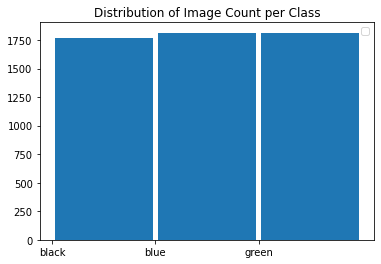

In [ ]:
black_bin_count = count_files(enel_data_path + '/Black')
blue_bin_count = count_files(enel_data_path + '/Blue')
green_bin_count = count_files(enel_data_path + '/Green')
data = [black_bin_count, blue_bin_count, green_bin_count]

plt.hist(['black', 'blue', 'green'], weights=data, bins=range(4), rwidth=.95)
plt.legend()
plt.title('Distribution of Image Count per Class')
plt.show()

### 1.2 Sample of Data

In [ ]:
def plot_images (item_dir, first=10):
  all_item_names = os.listdir(item_dir)
  item_paths = [os.path.join(item_dir,file) for file in all_item_names][:5]
  print(item_paths)

  #configure fig size
  plt.figure(figsize=(10,10))
  for index, image_path in enumerate(item_paths):
    plt.subplot(5,5,index+1)
    img = plt.imread(image_path)
    plt.tight_layout()
    plt.imshow(img,cmap='gray')

['/temp/Data/ProfsData/Black/blackProf_345.png', '/temp/Data/ProfsData/Black/blackProf_912.png', '/temp/Data/ProfsData/Black/blackProf_630.png', '/temp/Data/ProfsData/Black/blackProf_1494.png', '/temp/Data/ProfsData/Black/blackProf_1319.png']
['/temp/Data/ProfsData/Blue/blueProf_874.png', '/temp/Data/ProfsData/Blue/blueProf_681.png', '/temp/Data/ProfsData/Blue/blueProf_1460.png', '/temp/Data/ProfsData/Blue/blueProf_1278.png', '/temp/Data/ProfsData/Blue/blueProf_1097.png']
['/temp/Data/ProfsData/Green/greenProf_380.png', '/temp/Data/ProfsData/Green/greenProf_1156.png', '/temp/Data/ProfsData/Green/greenProf_1553.png', '/temp/Data/ProfsData/Green/greenProf_504.png', '/temp/Data/ProfsData/Green/greenProf_1135.png']


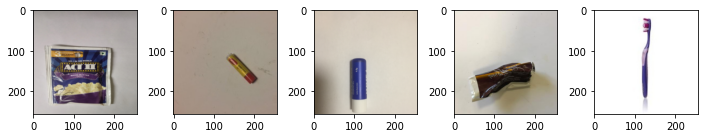

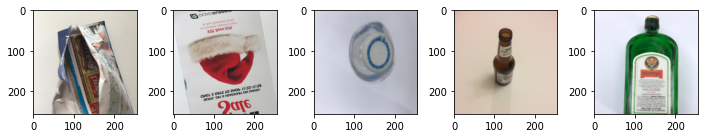

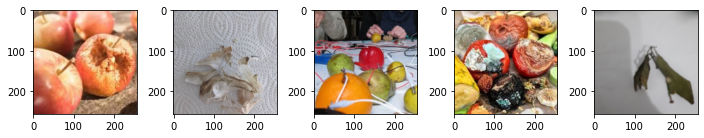

In [ ]:
plot_images(enel_data_path + '/Black')
plot_images(enel_data_path + '/Blue')
plot_images(enel_data_path + '/Green')

## 2. Train Test Split

In [47]:
## Train Validation Test Split
train_test_split(enel_data_path,'/train_val_test', 0.7, 0.2, 0.1)

Copying files: 5391 files [00:01, 2994.56 files/s]


## 3. VGG16 - ImageNet - Transfer Learning


In [50]:
## Data Augmentation
image_augmentation = ImageDataGenerator(horizontal_flip=True, 
                         vertical_flip=True,
                         width_shift_range = 0.1,
                         height_shift_range=0.1,
                         rotation_range=15,
                         fill_mode='nearest',
                         brightness_range=[0.75,1.25],
                         zoom_range=0.25,
                         rescale=1.0/255,
                         preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

test=ImageDataGenerator(rescale=1.0/255)

In [48]:
batch_size = 32
image_size = (224,224)

In [49]:
train_generator = image_augmentation.flow_from_directory('/train_val_test/train',batch_size=batch_size,
                                            target_size=image_size,
                                            class_mode='categorical',
                                            shuffle=True)

validation_generator = image_augmentation.flow_from_directory('/train_val_test/val',batch_size=batch_size,
                                            target_size=image_size,
                                            class_mode='categorical',
                                            shuffle=True
                                            )

test_generator = test.flow_from_directory('/train_val_test/test',batch_size=batch_size,
                                            target_size=image_size,
                                            class_mode='categorical',
                                            shuffle=True
                                          )

Found 3772 images belonging to 3 classes.
Found 1077 images belonging to 3 classes.
Found 542 images belonging to 3 classes.


In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Black', 1: 'Blue', 2: 'Green'}

In [ ]:
num_epochs = 5
step_size_train=train_generator.n//train_generator.batch_size
step_size_validation =validation_generator.n//validation_generator.batch_size
step_size_test =test_generator.n//test_generator.batch_size

model = VGG16_transfer_learning()

history = model.fit(train_generator, epochs=num_epochs, steps_per_epoch=step_size_train,validation_data=validation_generator,
                    validation_steps=step_size_validation)

score = model.evaluate(test_generator, steps=step_size_test)

Epoch 1/5
117/117 [==============================] - ETA: 0s - loss: 0.9548 - accuracy: 0.5901

KeyboardInterrupt: ignored

In [ ]:
print(score)

## 4. VGG16 - Without Transfer Learning

In [53]:
## Data Augmentation
image_augmentation = ImageDataGenerator(horizontal_flip=True, 
                         vertical_flip=True,
                         width_shift_range = 0.1,
                         height_shift_range=0.1,
                         rotation_range=15,
                         fill_mode='nearest',
                         brightness_range=[0.75,1.25],
                         zoom_range=0.25,
                         rescale=1.0/255,
                         )

test=ImageDataGenerator(rescale=1.0/255)

In [54]:
batch_size = 32
image_size = (224,224)

In [55]:
train_generator = image_augmentation.flow_from_directory('/train_val_test/train',batch_size=batch_size,
                                            target_size=image_size,
                                            class_mode='categorical',
                                            shuffle=True)

validation_generator = image_augmentation.flow_from_directory('/train_val_test/val',batch_size=batch_size,
                                            target_size=image_size,
                                            class_mode='categorical',
                                            shuffle=True
                                            )

test_generator = test.flow_from_directory('/train_val_test/test',batch_size=batch_size,
                                            target_size=image_size,
                                            class_mode='categorical',
                                            shuffle=True
                                          )

Found 3772 images belonging to 3 classes.
Found 1077 images belonging to 3 classes.
Found 542 images belonging to 3 classes.


In [66]:
num_epochs = 5
step_size_train=train_generator.n//train_generator.batch_size
step_size_validation =validation_generator.n//validation_generator.batch_size
step_size_test =test_generator.n//test_generator.batch_size

model = VGG16_wo_transfer_learning()
print(model.summary())

# history = model.fit(train_generator, epochs=num_epochs, steps_per_epoch=step_size_train,validation_data=validation_generator,
#                     validation_steps=step_size_validation)

# score = model.evaluate(test_generator, steps=step_size_test)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_9   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)              

## 5. EfficientNet - Transfer Learning

## 6. EfficientNet - Without Transfer Learning

## 7. CNN